In [27]:
# Tro to batch the data using xbatcher instead:
import xbatcher as xb
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from datetime import datetime
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import History

import sys
sys.path.append("../")

from src.processing import windsat_datacube

In [2]:
folder_path = "../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
ds

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


<xarray.Dataset> Size: 3GB
Dimensions:         (day_number: 21, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 121kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 60kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 697MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) int32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [3]:
# Select where there is data.
mask = ds.notnull()
mask = mask.compute()
ascds = ds.where(mask, drop=True).sel(swath_sector = 0)
# ascds.tbtoa.sel(day_number=1, polarization = 0, frequency_band = 0).plot()

In [175]:
asc_bgen = xb.BatchGenerator(
    ds=ascds,
    input_dims ={"latitude_grid":1,"longitude_grid":1, "day_number":21},
    )


In [92]:
print(len(asc_bgen))
asc_bgen[0].sel(sample=0)

training_example = asc_bgen[0][["tbtoa","time","longitude","latitude"]]

1036800


In [109]:
mask = ds.notnull()
mask = mask.compute()
fds = ds.where(mask, drop=True)
fds

<xarray.Dataset> Size: 3GB
Dimensions:         (day_number: 21, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB -89.88 -89.62 ... 89.62 89.88
    lon             (longitude_grid) float32 6kB 180.1 180.4 ... 179.6 179.9
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 121kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 60kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) float64 336B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 168B 18.68 ... 37.02
    frequency_hpol  (day_number, frequency_band) float32 168B 18.73 ... 37.02
    eia_nominal     (day_number, frequency_band) float32 168B 55.57 ... 53.2
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 697MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) float64 348MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [5]:
bgen = xb.BatchGenerator(
    ds=ascds,
    input_dims ={"latitude_grid":50,"longitude_grid":50, "day_number":11},
    )
print(len(bgen))
bgen[0].to_dataframe()

392


longitude  ...  polarization
day_number longitude_grid latitude_grid frequency_band polarization             ...              
1          0              0             0              0               180.125  ...             0
                                                       1               180.125  ...             1
                                        1              0               180.125  ...             0
                                                       1               180.125  ...             1
                          1             0              0               180.125  ...             0
...                                                                        ...  ...           ...
11         49             48            1              1               192.375  ...             1
                          49            0              0               192.375  ...             0
                                                       1               192.375  ...             1
                                        1              0               192.375  ...             0
                                                       1               192.375  ...             1

[110000 rows x 17 columns]

In [6]:

def transform_batch(batch: pd.DataFrame):

    # Select desired dvars:
    dvars = ["tbtoa","surtep_ERA5","lat","lon","time"]
    batch = batch[dvars]

    # Remove missing data
    batch = batch.dropna()

    # We want the day_number value as an input
    batch.reset_index(inplace=True)

    # Transform the variables time, lon and day
    global_bias = (datetime(2017, 1, 1, 0, 0, 0) - datetime(2000, 1, 1, 0, 0)).total_seconds()
    batch["time"] += - global_bias - (batch["day_number"] - 1)* 24 * 60 * 60

    batch["time"] = batch["time"].apply(
        lambda x: np.sin(2 * np.pi * x / (24 * 60 * 60))
    )
    
    # Lon and lat transformations, to have a number between -1 and 1
    batch["lon"] = batch["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
    batch["lat"] = batch["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

    # pivot the tbtoa and time columns into 4 and 2 respectivelly

    # Create new tbtoa columns based on frequency_band and polarization
    batch['tbtoa_18Ghz_V'] = batch.apply(lambda row: row['tbtoa'] if row['frequency_band'] == 0 and row['polarization'] == 0 else None, axis=1)
    batch['tbtoa_18Ghz_H'] = batch.apply(lambda row: row['tbtoa'] if row['frequency_band'] == 0 and row['polarization'] == 1 else None, axis=1)
    batch['tbtoa_37Ghz_V'] = batch.apply(lambda row: row['tbtoa'] if row['frequency_band'] == 1 and row['polarization'] == 0 else None, axis=1)
    batch['tbtoa_37Ghz_H'] = batch.apply(lambda row: row['tbtoa'] if row['frequency_band'] == 1 and row['polarization'] == 1 else None, axis=1)

    # Create new time columns based on frequency_band
    batch['time_18Ghz'] = batch.apply(lambda row: row['time'] if row['frequency_band'] == 0 else None, axis=1)
    batch['time_37Ghz'] = batch.apply(lambda row: row['time'] if row['frequency_band'] == 1 else None, axis=1)

    # Forward fill the new columns to fill None values
    batch[
        [
            'tbtoa_18Ghz_V',
            'tbtoa_18Ghz_H',
            'tbtoa_37Ghz_V',
            'tbtoa_37Ghz_H',
            'time_18Ghz',
            'time_37Ghz'
        ]
    ] = batch[
        [
            'tbtoa_18Ghz_V',
            'tbtoa_18Ghz_H',
            'tbtoa_37Ghz_V',
            'tbtoa_37Ghz_H',
            'time_18Ghz',
            'time_37Ghz'
        ]
    ].ffill()

    # Drop duplicate rows if necessary
    batch = batch.drop_duplicates(subset=['day_number', 'longitude_grid', 'latitude_grid', 'frequency_band', 'polarization'])
    batch.dropna(inplace=True)

    # Remove unwanted columns
    batch.drop(columns=['tbtoa', 'time',"latitude_grid","longitude_grid","polarization","frequency_band"], inplace=True)

    return batch


def xy_split(batch:pd.DataFrame):
    y_column = "surtep_ERA5"

    X = batch[[col for col in batch.columns if col != y_column]]
    y = batch[y_column]

    return X ,y


In [7]:
batch = bgen[0].to_dataframe()
batch = transform_batch(batch)
batch

,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz
3,1,262.643127,-0.993323,-0.002182,226.079987,184.817490,231.524994,202.434998,0.394585,0.393823
4,1,262.646576,-0.992810,-0.002182,225.535004,184.817490,231.524994,202.434998,0.394551,0.393823
5,1,262.646576,-0.992810,-0.002182,225.535004,184.567505,231.524994,202.434998,0.394551,0.393823
6,1,262.646576,-0.992810,-0.002182,225.535004,184.567505,231.807495,202.434998,0.394551,0.393790
7,1,262.646576,-0.992810,-0.002182,225.535004,184.567505,231.807495,204.514999,0.394551,0.393790
...,...,...,...,...,...,...,...,...,...,...
19991,6,272.580627,-0.977692,-0.214309,181.262497,95.492500,204.532501,130.852493,0.356666,0.355874
19992,6,272.800568,-0.976766,-0.214309,181.000000,95.492500,204.532501,130.852493,0.356506,0.355874
19993,6,272.800568,-0.976766,-0.214309,181.000000,96.440002,204.532501,130.852493,0.356506,0.355874
19994,6,272.800568,-0.976766,-0.214309,181.000000,96.440002,204.345001,130.852493,0.356506,0.355701


In [ ]:
# # pivot the tbtoa and time columns into 4 and 2 respectivelly

# # Create new tbtoa columns based on frequency_band and polarization
# batch['tbtoa_18Ghz_V'] = batch.apply(lambda row: row['tbtoa'] if row['frequency_band'] == 0 and row['polarization'] == 0 else None, axis=1)
# batch['tbtoa_18Ghz_H'] = batch.apply(lambda row: row['tbtoa'] if row['frequency_band'] == 0 and row['polarization'] == 1 else None, axis=1)
# batch['tbtoa_37Ghz_V'] = batch.apply(lambda row: row['tbtoa'] if row['frequency_band'] == 1 and row['polarization'] == 0 else None, axis=1)
# batch['tbtoa_37Ghz_H'] = batch.apply(lambda row: row['tbtoa'] if row['frequency_band'] == 1 and row['polarization'] == 1 else None, axis=1)

# # Create new time columns based on frequency_band
# batch['time_18Ghz'] = batch.apply(lambda row: row['time'] if row['frequency_band'] == 0 else None, axis=1)
# batch['time_37Ghz'] = batch.apply(lambda row: row['time'] if row['frequency_band'] == 1 else None, axis=1)

# # Forward fill the new columns to fill None values
# batch[
#     [
#         'tbtoa_18Ghz_V',
#         'tbtoa_18Ghz_H',
#         'tbtoa_37Ghz_V',
#         'tbtoa_37Ghz_H',
#         'time_18Ghz',
#         'time_37Ghz'
#     ]
# ] = batch[
#     [
#         'tbtoa_18Ghz_V',
#         'tbtoa_18Ghz_H',
#         'tbtoa_37Ghz_V',
#         'tbtoa_37Ghz_H',
#         'time_18Ghz',
#         'time_37Ghz'
#     ]
# ].ffill()

# # Drop duplicate rows if necessary
# batch = batch.drop_duplicates(subset=['day_number', 'longitude_grid', 'latitude_grid', 'frequency_band', 'polarization'])
# batch.dropna(inplace=True)

# # Remove unwanted columns
# batch.drop(columns=['tbtoa', 'time',"latitude_grid","longitude_grid","polarization","frequency_band"], inplace=True)
# batch

In [228]:
x_train, y_train = xy_split(batch)
x_train.shape

(19993, 9)

In [8]:
# Model definition:
# For now we define the model here, later we will have elsewhere.

n_vars = 9

model = Sequential([
    Input((n_vars,)),
    BatchNormalization(),
    Dense(30,activation="relu", name = "hiddenLayer1"),
    Dense(20,activation="relu", name = "hiddenLayer2"),
    Dense(10,activation="relu", name = "hiddenLayer3"),
    Dense(1,activation="relu", name = "outputLayer")
])

model.compile(
    optimizer = "adam",
    loss ="mse",
    metrics = ["mse"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,177 (4.60 KB)

 Trainable params: 1,159 (4.53 KB)

 Non-trainable params: 18 (72.00 B)

In [19]:
def model_wrapper() -> Sequential:
    """ 
    Create a keras.model object with this architecture
    """

    n_vars = 9

    model = Sequential([
        Input((n_vars,)),
        BatchNormalization(),
        Dense(30,activation="relu", name = "hiddenLayer1"),
        Dense(20,activation="relu", name = "hiddenLayer2"),
        Dense(10,activation="relu", name = "hiddenLayer3"),
        Dense(1,activation="relu", name = "outputLayer")
    ])

    model.compile(
        optimizer = "adam",
        loss ="mse",
        metrics = ["mse"]
    )

    return model
    



In [230]:
# Training loop

full_history = None
# TODO: make this sequential process into a parallel one (retrieve data - train model)
for i, batch in enumerate(bgen):
    batch = batch.to_dataframe()
    batch = transform_batch(batch)

    X, y = xy_split(batch)
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 13)

    batch_history = model.fit(x_train, y_train, epochs=1, validation_data=(x_test,y_test))

    # Manage the history of each training run
    if full_history is None:
        full_history = batch_history
    else:
        for key in full_history.history.keys():
            full_history.history[key].extend(batch_history.history[key])

    print(f"Batch {i} out of {len(bgen)} - {i/len(bgen)}%")

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 48857.3672 - mse: 48857.3672 - val_loss: 713.6321 - val_mse: 713.6321
0.0
576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1518.0789 - mse: 1518.0789 - val_loss: 334.5284 - val_mse: 334.5284
0.002551020408163265
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 202.2489 - mse: 202.2489 - val_loss: 51.6903 - val_mse: 51.6903
0.00510204081632653
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 113.0559 - mse: 113.0559 - val_loss: 38.4134 - val_mse: 38.4134
0.007653061224489796
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 35.1927 - mse: 35.1927 - val_loss: 12.1769 - val_mse: 12.1769
0.01020408163265306
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.7327 - mse: 18.7327 - val_loss: 8.3510 - val_mse: 8.3510
0.012755102040816327
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 17.0540 - mse: 17.0540 - val_loss: 13.2893 - val_mse: 13.2893
0.015306122448979591
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 12.0202 - mse: 12.0202 -

NOTES:  
since ,to my knowledge, xbatcher does not support missing value omission, I have to filter them myself with pandas in each batch, which results in variable batch size for each training epoch

This might cause problems if the batch is empty (?)

--- 

I noticed that for small batches the mse goes up substantially. 

First round of training with all 21 days took 27 mins in my local machine

IDEA:

If the training batch is too small (below 1000 for example) train for 2 epochs instead of 1.

another option is to skip the training and retrieve the next batch, then train with 2 batches if the total length is more than 1000.



NameError: name 'full_history' is not defined

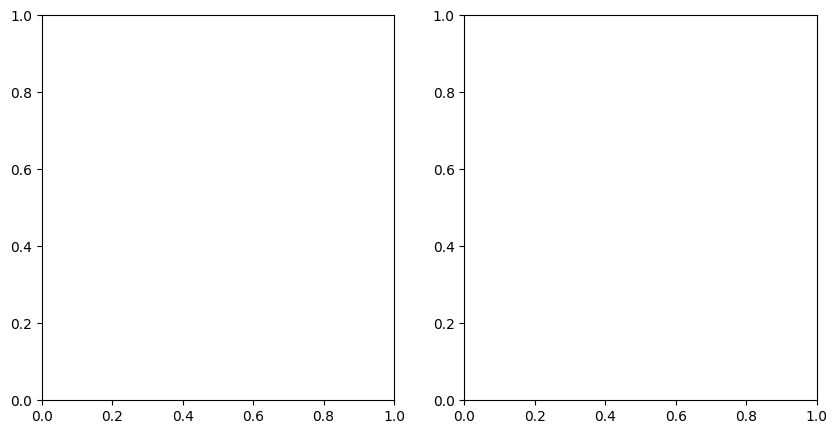

In [31]:
# Plot the training history:
fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].plot(full_history.history["loss"])
ax[1].plot(full_history.history["loss"][-len(full_history.history["loss"])//2:])

In [232]:
model.predict(x_train)[:5]

2459/2459 ━━━━━━━━━━━━━━━━━━━━ 3s 969us/step


array([[248.89058],
       [246.61288],
       [248.60332],
       [250.10327],
       [247.44875]], dtype=float32)

In [241]:
# Save FINAL model weights and history data.
weights_path = "../data/processed/model_weights/xbatcher_test3.weights.h5"
model.save_weights(weights_path)

history_path = "../data/processed/model_weights/xbatcher_test.json"

with open(history_path, "wb") as file:
    pickle.dump(full_history, file)

In [242]:
# Open and load later with 
model.load_weights(weights_path)

with open(history_path, 'rb') as file:
    history = pickle.load(file)


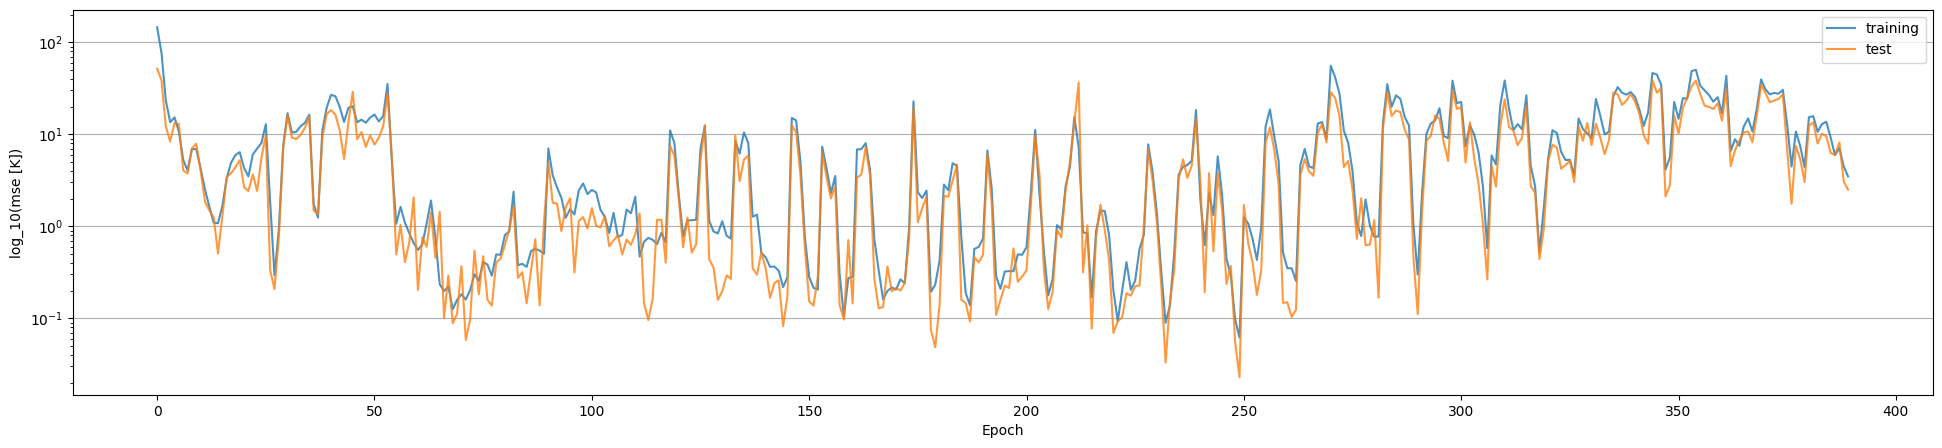

In [270]:
plt.figure(figsize = (24,5))
plt.plot(history.history["loss"][2:], alpha=0.8, label = "training")
plt.plot(history.history["val_loss"][2:],  alpha=0.8, label = "test")
plt.legend()
plt.yscale("log")
plt.ylabel("log_10(mse [K])")
plt.xlabel("Epoch")
plt.grid(axis="y")

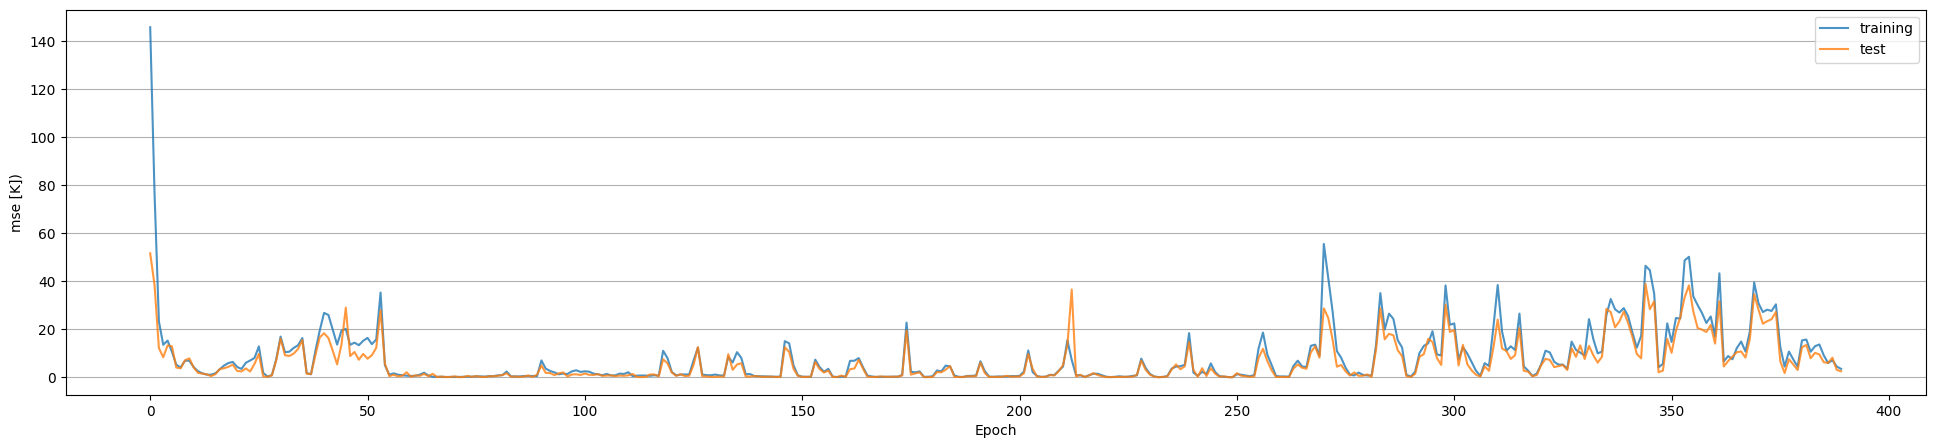

In [271]:
plt.figure(figsize = (24,5))
plt.plot(history.history["loss"][2:], alpha=0.8, label = "training")
plt.plot(history.history["val_loss"][2:],  alpha=0.8, label = "test")
plt.legend()
plt.ylabel("mse [K])")
plt.xlabel("Epoch")
plt.grid(axis="y")

In [ ]:
# TODO: Training is too unstable, but promessing. Run this with bigger batches
# (ensure that the batch dataframe is at least min_size, if it)
""" 
Retrieve a batch dataframe.

    If len(batch) >= min_size:
        training_batch, leftovers = batch[:min_size], batch[min_size:]

    Else:
        continue
        
    
"""

In [20]:



def training_step(training_batch: pd.DataFrame, history: History=None ) -> History :
    """ 
    Single training step with a dataframe 2000 samples long. returned expanded history
    """
    X, y = xy_split(training_batch)
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 13)
    batch_history = model.fit(x_train, y_train, epochs=1, validation_data=(x_test,y_test))

    # Manage the history of each training run
    if history is None:
        history = batch_history
    else:
        for key in history.history.keys():
            history.history[key].extend(batch_history.history[key])

    return history


In [30]:
# Leftovers training loop
""" 
Training batches are full of nan values, so the size of each batch is different and its making training unstable.

In this current implementation, we skip the last batch if is not big enought.
"""
# Training loop
model = model_wrapper()
history = None
min_samples = 32000 # model batch training is 32 by default, so this makes nice numbers appear.
leftovers = pd.DataFrame()

# TODO: make this sequential process into a parallel one (retrieve data - train model)
for i, batch in enumerate(bgen):
    batch = batch.to_dataframe()
    batch = transform_batch(batch)

    batch = pd.concat([leftovers,batch])
    batch.reset_index()

    if batch.shape[0] < min_samples:
        leftovers = pd.concat([leftovers,batch])
        continue

    training_batch, leftovers = batch[:min_samples], batch[min_samples:]

    history = training_step(training_batch, history)

    while leftovers.shape[0] > min_samples:
        training_batch, new_leftovers = leftovers[:min_samples], leftovers[min_samples:]
        history = training_step(training_batch, history)
        leftovers = new_leftovers


    print(f"Standard Batch {i} out of {len(bgen)} - {100*i/len(bgen):.2f}%")

900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 834us/step - loss: 29862.4277 - mse: 29862.4277 - val_loss: 412.7729 - val_mse: 412.7729
Standard Batch 1 out of 392 - 0.26%
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - loss: 401.9989 - mse: 401.9989 - val_loss: 59.8123 - val_mse: 59.8123
Standard Batch 3 out of 392 - 0.77%
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - loss: 119.1277 - mse: 119.1277 - val_loss: 19.7721 - val_mse: 19.7721
Standard Batch 4 out of 392 - 1.02%
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - loss: 16.2370 - mse: 16.2370 - val_loss: 8.0135 - val_mse: 8.0135
Standard Batch 5 out of 392 - 1.28%
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - loss: 11.8722 - mse: 11.8722 - val_loss: 6.9688 - val_mse: 6.9688
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - loss: 6.7237 - mse: 6.7237 - val_loss: 3.5183 - val_mse: 3.5183
Standard Batch 6 out of 392 - 1.53%
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - loss: 7.9136 - mse: 7.9136 - val_loss: 3.9511 - val_mse: 3.9511
900/900 ━━━━━━━━━━━━━━━━━━━━ 

In [32]:
# Save this new model history and such 
# Save FINAL model weights and history data.
weights_path = "../data/processed/model_weights/xbatcher_test3.weights.h5"
model.save_weights(weights_path)

history_path = "../data/processed/model_weights/xbatcher_test3.json"

with open(history_path, "wb") as file:
    pickle.dump(history, file)


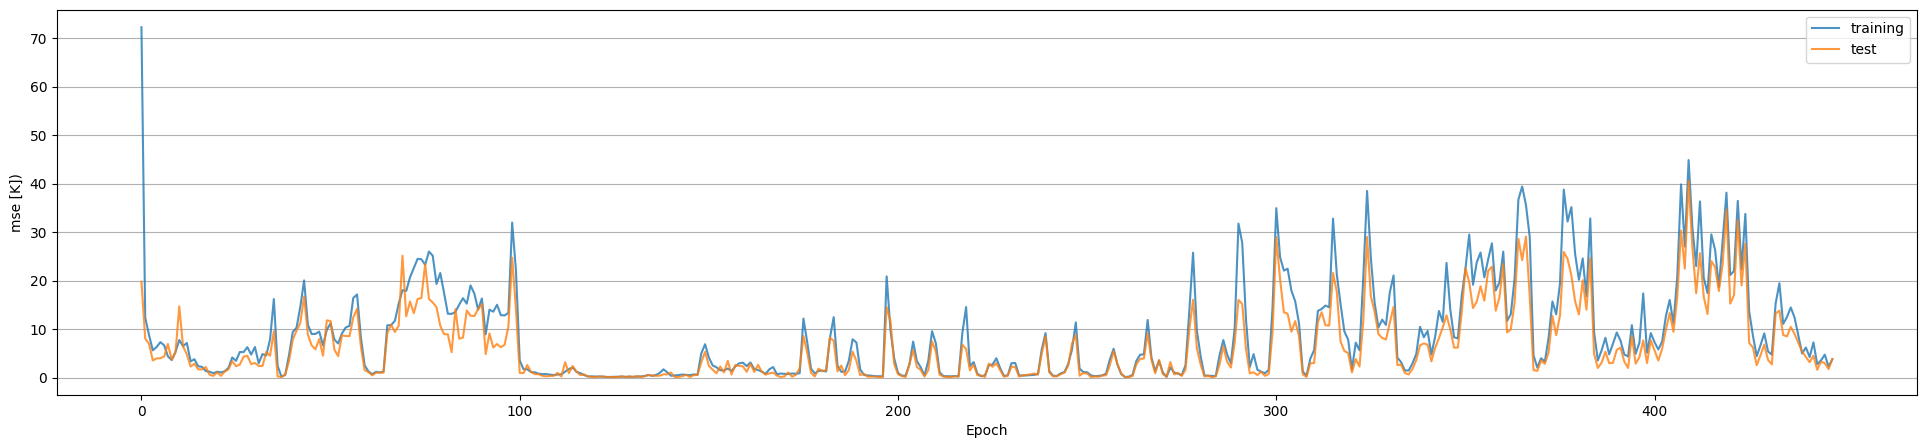

In [33]:

plt.figure(figsize = (24,5))
plt.plot(history.history["loss"][2:], alpha=0.8, label = "training")
plt.plot(history.history["val_loss"][2:],  alpha=0.8, label = "test")
plt.legend()
plt.ylabel("mse [K])")
plt.xlabel("Epoch")
plt.grid(axis="y")

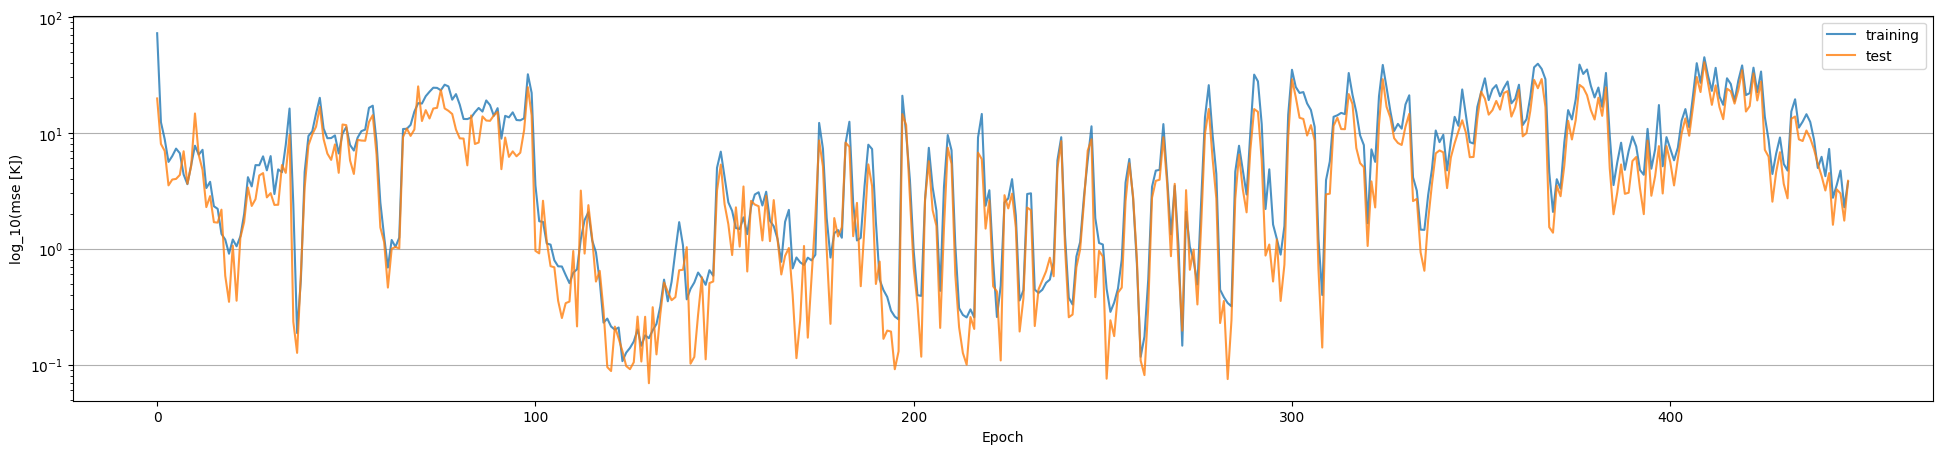

In [34]:
# history plot #TODO make this into a function maybe? 
plt.figure(figsize = (24,5))
plt.plot(history.history["loss"][2:], alpha=0.8, label = "training")
plt.plot(history.history["val_loss"][2:],  alpha=0.8, label = "test")
plt.legend()
plt.yscale("log")
plt.ylabel("log_10(mse [K])")
plt.xlabel("Epoch")
plt.grid(axis="y")


---

i veliebe that my batches are not uniform ... 

Lets try to change the settings in xbatcher

---

On second thought, maybe there is too much difference between snow covered areas and bare soil, so whenever a batch contains too much snowy pixels, the training loss is higher.



In [ ]:
#TODO: load a model and test it on some real map data. 
""" 
Plot the map with lon-lat mse/diff with ERA5. 

# Select a day of data and a small region, (Europe is big, has lots of coastline and different land coverage)
"""

test_ds = ds.sel(lat=slice(30,60), lon=slice(-15,45), day_number = 1)
test_ds


In [ ]:
# TODO: Plot the lat-lon distribution of batches to test my hipothesis:
plt.scatter(x= bgen[0].lon.values, y=bgen[0].lat.values )
